# Logistic regression

The goal of this lab activity is to observe how logistic regression is applied and what the effects of its parameters are. The code snippets are largely adapted from Aurelien Geron, *Hands-On Machine Learning*, pg 139-144 and Muller and Guido, *Introduction to Machine Learning with Python*, pg 58-65. 

First import the libraries we'll use.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler


## Decision boundaries

On Friday we considered what would happen if we used linear regression as a means of classification on the intuition that a regressor's real number result can be mapped to a class. Somehow or another, that mapping needs to be made using a decision boundary: any value below the boundary is class 0, anything above is class 1 (we'll see about extending this to classification to more than two classes later). The naive way to make this decision is to feed the regressor through a step function. 

As we observed in class, a step function does not have a useful derivative, and so it cannot be used in a loss function for which we can take a gradient. To address this, we use a differentiable approximation of a step function, the *logistic* function $\sigma(t)$.

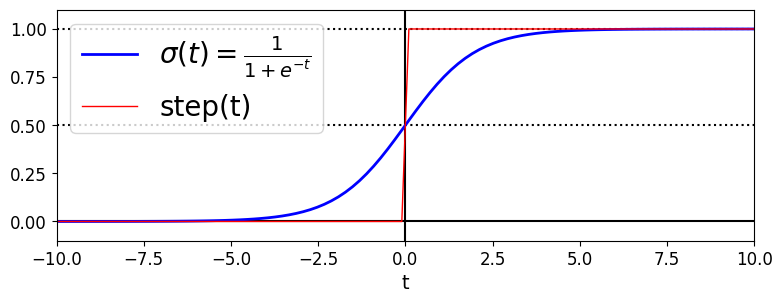

In [3]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
step = np.vectorize(lambda x : 0 if x <=0 else 1)(t)
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.plot(t, step, "r-", linewidth=1, label=r"step(t)")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

The logistic function has several nice properties that make it easy to use for gradients, which we'll explore next time. But for right now, the news is that *logistic regression* is like linear regression but fed into a logistic function to make a smooth decision boundary. Let's see what this model does with data.

Let's grab the tried-and-true iris data set, but modify it so that it can be used for binary classification. We'll keep the species Iris Virginica as one class, but toss the other two species (Iris Versicolor and Iris Setosa) together into a second class (non-Virginica).

In [4]:
from sklearn import datasets
iris = datasets.load_iris()
# Uncomment the either of the next two lines if you want to review the
# details of the iris dataset, including what the features mean
list(iris.keys())
#print(iris.DESCR)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

First let's go really simple. Use only a single feature.

In [5]:
X = iris["data"][:,3].reshape((len(iris["data"]), 1))  # petal width 
y = (iris["target"] == 2).astype(int)  # 1 if Iris-Virginica, else 0

In [6]:
X.shape

(150, 1)

Now train a logistic regressor using the implementation from sklearn. The `LogisticRegression` class has a whole bunch of options which we'll examine later. The actual training of the parameters is off-loaded to another library, and you can select which library is used through the `solver` parameter. "For small datasets, ‘liblinear’ is a good choice," according to the sklearn API. Since we're interested in the interaction between the decision boundary and the training data (as opposed to being interested in the accuracy of the classifier), we'll use the *entire dataset* as the training data rather than split it into a training set and a test set.

In [7]:
log_reg = LogisticRegression(solver="liblinear")
log_reg.fit(X, y)

LogisticRegression(solver='liblinear')

Now let's plot the one feature vs the two classes.

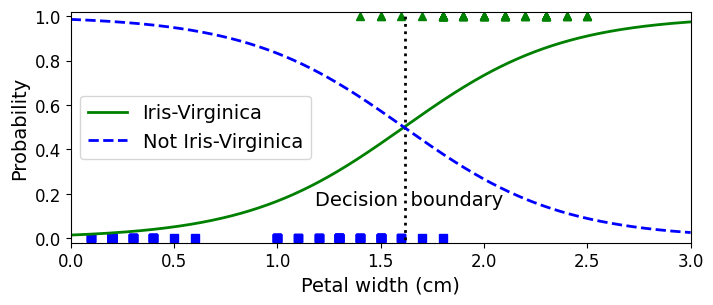

In [8]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

Look carefully in the code above. The method `predict_proba` returns the probability that a given datapoint is in each class. For example, data point 0:

In [10]:
y_proba[0]

array([0.98554411, 0.01445589])

Read that as the probabilities, respectively, of this point being in class 0 and 1. See how the variable `decision_boundary` was computed. This gives the petal width less than which an iris sample is more likely to be Virginica.

In [11]:
decision_boundary

array([1.61561562])

We can try the other features, but they don't work as well:

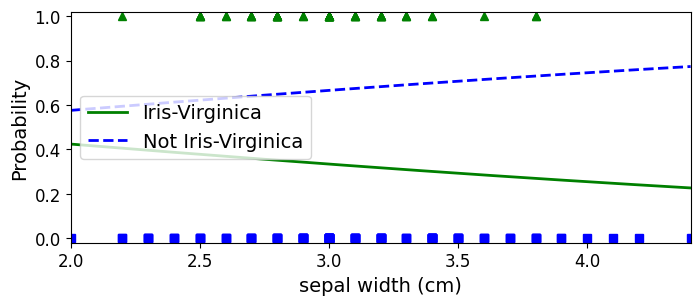

In [17]:
# pick a feature: 0, 1, or 2 (we already did 3)
f = 1

X = iris["data"][:,f].reshape((len(X), 1))  
y = (iris["target"] == 2).astype(int)  # 1 if Iris-Virginica, else 0

x_min = min(X[:,0])
x_max = max(X[:,0])

log_reg = LogisticRegression(solver="liblinear")
log_reg.fit(X, y)

X_new = np.linspace(x_min, x_max, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
# If no observations are classified Iris_Virginica, then don't show any decision boundary
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0] if len(X_new[y_proba[:, 1] >= 0.5]) > 0 else None

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
if decision_boundary :
    plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
if decision_boundary :
    plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.xlabel(iris.feature_names[f], fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([x_min, x_max, -0.02, 1.02])
plt.show()

In this next plot (also taken from Geron), we look at the decision boundary in two dimensions. Grabbing only petal length and petal width, we train a classifier, plot the points, and show the probability boundaries: 

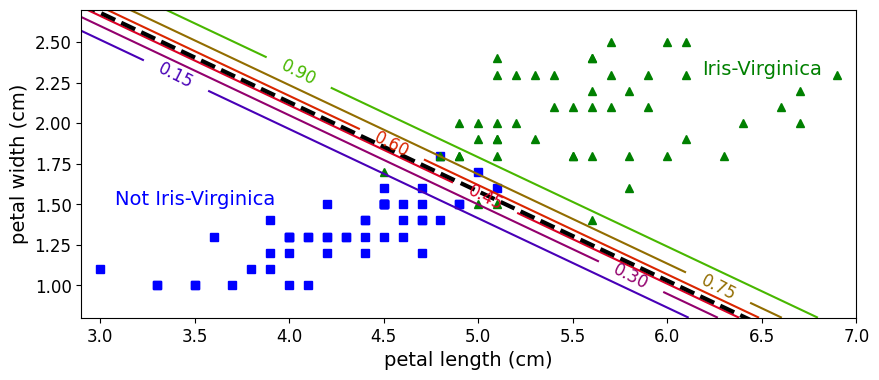

In [24]:
# The next line selects petal length and width as the two features. 
# You can change this to experiment with other features.
features = (2, 3)

X = iris["data"][:, features]  
y = (iris["target"] == 2).astype(int)

# C is a parameter controlling regularization, similar to alpha. We'll talk about it more later.
log_reg = LogisticRegression(solver="liblinear", C=10**10)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))j
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel(iris.feature_names[features[0]], fontsize=14)
plt.ylabel(iris.feature_names[features[1]], fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

Notice that the boundary that the classifier draws is necessarily a line, but if you look carefully at the points, it's apparent that there is no line that perfectly separates them. Logistic regression is linear model in the sense that it classifies by finding a line (or plane or hyperplane) that separates data.

How well does it do as a classifier? Let's assess logistic regression using accuracy, precision, and recall. (This cell uses all four features. Run it several times, since the results you get will be different depending on how the training and test are randomly split.)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(iris['data'], (iris["target"] == 2).astype(int))
log_reg = LogisticRegression(solver="liblinear", C=10**10)
log_reg.fit(X_train, y_train)

y_train_classify = log_reg.predict(X_train)
y_test_classify = log_reg.predict(X_test)
0.985544
true_virginica = np.sum(np.logical_and(y_test_classify == 1, y_test_classify == y_test))
false_virginica = np.sum(np.logical_and(y_test_classify == 1, y_test_classify != y_test))
true_non_virginica = np.sum(np.logical_and(y_test_classify == 0, y_test_classify == y_test))
false_non_virginica = np.sum(np.logical_and(y_test_classify == 0, y_test_classify != y_test))
print("Accuracy: " + str((true_virginica + true_non_virginica)/ len(y_test)))
print("Precision: " + str(true_virginica / (true_virginica + false_virginica)))
print("Recall: " + str(true_virginica / (true_virginica + false_non_virginica)))

Accuracy: 0.9210526315789473
Precision: 0.8571428571428571
Recall: 0.9230769230769231


## Logistic regression and regularization

Think back to the linear regression lab when we visualized the effects of regularization by looking at the values of the parameters for different values of alpha. Here a similar plot, using the California housing data set.

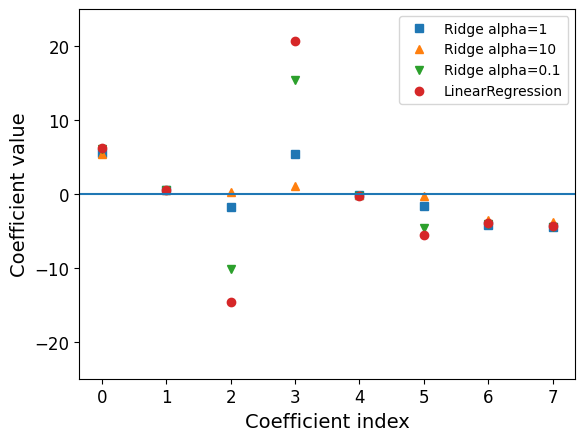

In [32]:
from sklearn.datasets import fetch_california_housing
calif = fetch_california_housing()
X = MinMaxScaler().fit_transform(calif.data)
y = calif.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

lr = LinearRegression().fit(X_train, y_train)
ridge = Ridge().fit(X_train, y_train)
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)


plt.plot(ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")

plt.plot(lr.coef_, 'o', label="LinearRegression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient value")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-25, 25)
plt.legend()

For coefficients (that is, parametersss) 2 and 3 (think $\theta_2$ and $\theta_3$), the magnitude is large using plain linear regression. Regularization penalizes large large parameters, and you can see the effect of larger alphas pulling those parameters closer to 0.

Logistic regression similarly uses regularization. Read what the [documentation for sklearn's LogisticRegression]( https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) says about the parameters `penalty` and `C`. In particular notice that regularization is on by default (using `l2`, so the equivalent of ridge regression) and that `C` is actually the inverse of `alpha` for some reason (greater `C`, less regularization). 

We're going to test the effects of fiddling with `C`, but first let's load the breast cancer data and see how well it does. 

In [33]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

We'll use the sklearn's own accuracy scoring function rather than calculate it ourselves. Run the following cell several times to see how much the random train/test splitting makes a difference.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target)
logreg = LogisticRegression(solver="liblinear").fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.958
Test set score: 0.937


Those results are pretty good and fairly consistent. You may have observed some trials where the test set scored even higher than the training set. Muller and Guido say that with the training set and test set being that close, we may be underfitting the training data---that is, that there is too much regularization. Remember that by default sklearn's `LogisticRegression` does the equivalent of ridge regression with `C`=1. A greater `C` makes a more flexible model (*flexible* in the sense of more readily fitting the training data), and a lower `C` is more regularized/less flexible/less fitting to the training data. Let's try both directions. (Again, try these several times to observe the effect over several train-test splits).

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target)
print("C = 1 (default)")
logreg = LogisticRegression(solver="liblinear").fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))
print("C = 100")
logreg100 = LogisticRegression(solver="liblinear", C=100).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg100.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg100.score(X_test, y_test)))
print("C = .01")
logreg001 = LogisticRegression(solver="liblinear", C=0.01).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg001.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

C = 1 (default)
Training set score: 0.955
Test set score: 0.951
C = 100
Training set score: 0.977
Test set score: 0.965
C = .01
Training set score: 0.937
Test set score: 0.930


What do you observe?

Let's see if we can map this affect over a range of values for `C`. The following plots the accuracy on a training and test set over `C` ranging from .001 to 1000. The `C` values are ranging over (and being plotted on) a log scale. (Again, run this several times.)

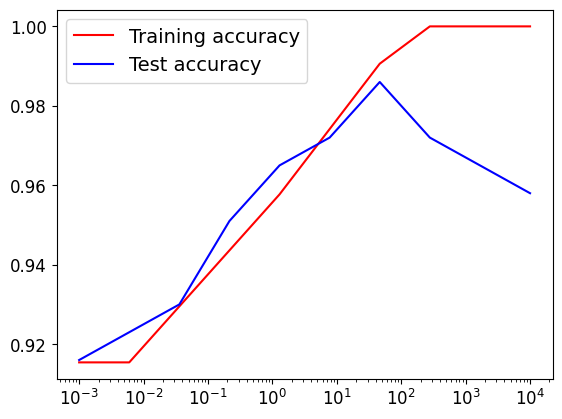

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target)
c_vals = np.logspace(-3, 4, num=10, base=10)
#c_vals = [1.]
regs = [LogisticRegression(penalty = "l1", max_iter=500, solver="liblinear", C=c).fit(X_train, y_train) for c in c_vals]
train_accs = np.array([lg.score(X_train, y_train) for lg in regs])
test_accs = np.array([lg.score(X_test, y_test) for lg in regs])
plt.xscale("log")
plt.plot(c_vals, train_accs, "r-", label="Training accuracy")
plt.plot(c_vals, test_accs, "b-", label="Test accuracy")
plt.legend(loc="upper left", fontsize=14)

As with linear and ridge regression, we can observe the effect at the feature level by plotting the coefficient value (that is, weight or theta component) for each feature. (This uses the `logreg`, `logreg100`, and `logreg001` from your most recent executing of the cell before last. To see how much different splits effect this, re-run that cell.)

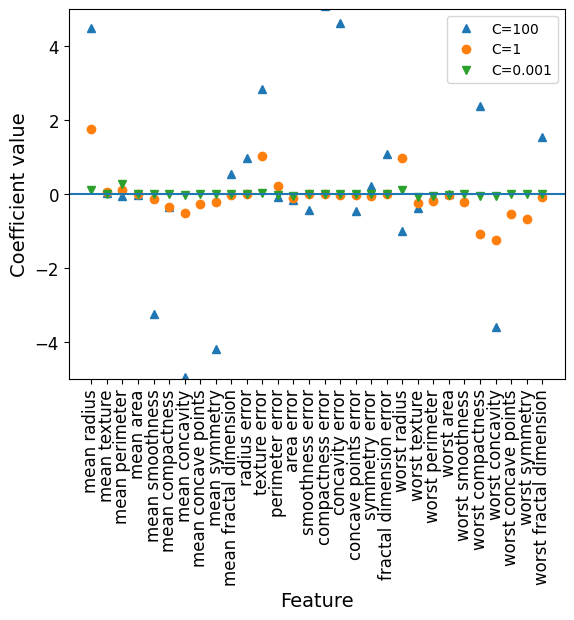

In [46]:
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg.coef_.T, 'o', label="C=1")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-5, 5)
plt.xlabel("Feature")
plt.ylabel("Coefficient value")
plt.legend()

Now go back and redo these recent experiements but with `penalty` set to `"l1`, that is, to use the equivalent to LASSO regression. See the `LogisticRegression` documentation for more information as necessary.

## Multiclass classification

Finally, how can we use this for classification when we have more than two classes? Since the iris data set has three classes, we'll switch back to that one for this purpose. (The code here is adapted from Geron.) 

One approach is to take the intuition from our earlier experiement where we singled out Virginica and classified Virginica vs non-Virginica. We can do that repeatedly for each class (Setosa vs non-Setosa, Versicolor vs non-Versicolor) and combine the results to find for each data point a probability that is is in each of the three classes. This is called a "one vs. rest" approach, or "ovr". The `LogisticRegression` allows us to select this approach through the `multi_class` parameter.

(Even though we're using all three classes, we'll use only two features so that we can visualize the results in two dimensions.)

In [49]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]


In [50]:
# The LogisticRegression class used to have a multi_class option:
# ovr_reg = LogisticRegression(multi_class="ovr",solver="liblinear", C=10)
# But that's deprecated in favor of using OneVsRestClassifier with a LogisticRegression instance
# as the estimator.
from sklearn.multiclass import OneVsRestClassifier
ovr_reg = OneVsRestClassifier(LogisticRegression(solver="liblinear", C=10))
ovr_reg.fit(X, y)

OneVsRestClassifier(estimator=LogisticRegression(C=10, solver='liblinear'))

Now we can observe decision boundaries (and the regions they bound) and probability gradations on the three classes.

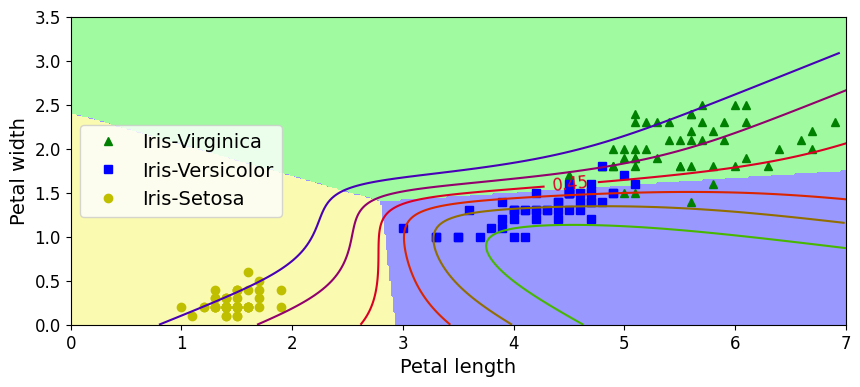

In [51]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = ovr_reg.predict_proba(X_new)
y_predict = ovr_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

An alternative is to use a function called *softmax*, which we might have time to talk about in class on Wednesday, depending on how long other things take. (If we don't have time to talk about softmax during the logistic regression unit, we'll have another opportunity later when we look at neural nets and related models.) For right now, think of it this way: for a given datapoint, the underlying regressor computes a score for each class, and then the softmax function uses those scores to determine probabilities for that data point being in each class.

It turns out that the `liblinear` solver can't do multiclass classification in any other way than one-vs.-rest, so we need to switch to the `lbfgs` solver to use the `multinomial` option, which is another name for softmax in this context. (Again, see the documentation for details on this.)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(iris['data'], (iris["target"] == 2).astype(int))
log_reg = LogisticRegression(solver="liblinear", C=10**10)
log_reg.fit(X_train, y_train)

y_train_classify = log_reg.predict(X_train)
y_test_classify = log_reg.predict(X_test)
0.985544
true_virginica = np.sum(np.logical_and(y_test_classify == 1, y_test_classify == y_test))
false_virginica = np.sum(np.logical_and(y_test_classify == 1, y_test_classify != y_test))
true_non_virginica = np.sum(np.logical_and(y_test_classify == 0, y_test_classify == y_test))
false_non_virginica = np.sum(np.logical_and(y_test_classify == 0, y_test_classify != y_test))
print("Accuracy: " + str((true_virginica + true_non_virginica)/ len(y_test)))
print("Precision: " + str(true_virginica / (true_virginica + false_virginica)))
print("Recall: " + str(true_virginica / (true_virginica + false_non_virginica)))

Accuracy: 0.9473684210526315
Precision: 1.0
Recall: 0.8571428571428571


In [76]:
# "multinomial" is now the defualt (or maybe only) multi_class option, so
# that parameter is deprecated
#softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg = LogisticRegression(solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10)

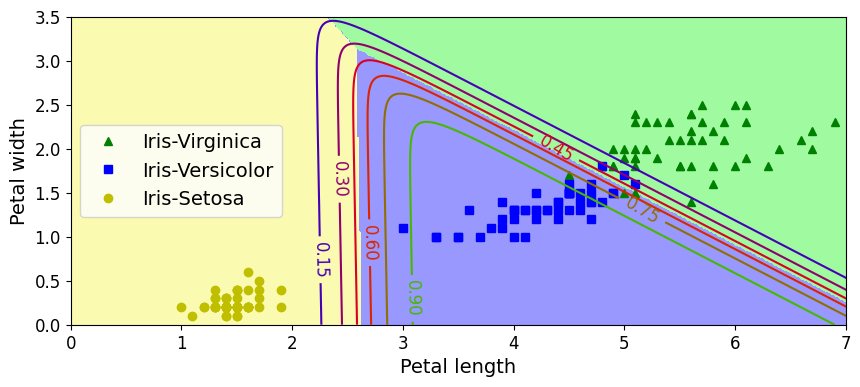

In [77]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

Using the code cells earlier in this note book, find out how accurate these classifiers are when you split the data into training and test sets. Can you adjust the parameters to the regressor to get better results?

## Further study

With the time that remains, experiment with logistic regression on another dataset of your choice. See
[the sklearn API](https://scikit-learn.org/stable/api/sklearn.datasets.html#module-sklearn.datasets) for how to load the datasets that come with that library.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(iris['data'], (iris["target"] == 2).astype(int))
log_reg = LogisticRegression(solver="liblinear", C=10**10)
log_reg.fit(X_train, y_train)

y_train_classify = log_reg.predict(X_train)
y_test_classify = log_reg.predict(X_test)
0.985544
true_virginica = np.sum(np.logical_and(y_test_classify == 1, y_test_classify == y_test))
false_virginica = np.sum(np.logical_and(y_test_classify == 1, y_test_classify != y_test))
true_non_virginica = np.sum(np.logical_and(y_test_classify == 0, y_test_classify == y_test))
false_non_virginica = np.sum(np.logical_and(y_test_classify == 0, y_test_classify != y_test))
print("Accuracy: " + str((true_virginica + true_non_virginica)/ len(y_test)))
print("Precision: " + str(true_virginica / (true_virginica + false_virginica)))
print("Recall: " + str(true_virginica / (true_virginica + false_non_virginica)))

Accuracy: 0.9473684210526315
Precision: 0.9444444444444444
Recall: 0.9444444444444444
